In [ ]:
import sys, os
sys.path.insert(0, os.path.abspath(".."))

In [ ]:
from scripts.utils_wandb import load_runname_group_map_from_file
from scripts.training_analyses import PerformanceBuildConfig, build_performance_table

# W&B project
ENTITY = "callumrlawson-pibbss"
PROJECT = "JAXUED_TEST"

# Metric family to analyze; choose one:
# - "return/"           (per-maze episodic return)
# - "solve_rate/"       (per-maze solve rate)
METRIC_PREFIX = "solve_rate/" # "return/"

# Step selection
STEP_KEY = "num_updates"
AT_STEP = None  # None => use last available per run; or set e.g. 30000

# Run grouping config
CFG_PATH = "/home/callum/projects/evo-ued/config/combine_results_30k.json"

# Load mapping and assemble per-maze performance at chosen step
runmap = load_runname_group_map_from_file(CFG_PATH)

perf_cfg = PerformanceBuildConfig(
    entity=ENTITY,
    project=PROJECT,
    runname_to_group=runmap,
    step_key=STEP_KEY,
    metric_prefix=METRIC_PREFIX,
    at_step=AT_STEP,
    use_cache=True,
    refresh=False,
)

df_perf = build_performance_table(perf_cfg)
df_perf.head()

/home/callum/projects/evo-ued/src/jaxued/performance_analysis.py:148: UserWarning: Duplicate runs for 'dr_softmin_eval250_seed9_30000a'. Using 5z2kz0cr (score=30000.0). Others: lwdyong6:21750.0, 5494bqdu:2000.0, g8ga87vx:2000.0
  warnings.warn(
/home/callum/projects/evo-ued/src/jaxued/performance_analysis.py:148: UserWarning: Duplicate runs for 'dr_baseline_eval250_seed9_30000a'. Using z2kg4331 (score=30000.0). Others: 4wxgkyo7:2000.0, tddvc36j:2000.0
  warnings.warn(
/home/callum/projects/evo-ued/src/jaxued/performance_analysis.py:148: UserWarning: Duplicate runs for 'dr_baseline_eval250_seed3_30000a'. Using kv90hilu (score=30000.0). Others: 7ufgpt9e:22500.0
  warnings.warn(


,group,run_id,run_name,maze,value,step,step_col
0,DR (evolutionary),5z2kz0cr,dr_softmin_eval250_seed9_30000a,Labyrinth2,0.380,30000.0,num_updates
1,DR (evolutionary),5z2kz0cr,dr_softmin_eval250_seed9_30000a,StandardMaze3,0.824,30000.0,num_updates
2,DR (evolutionary),5z2kz0cr,dr_softmin_eval250_seed9_30000a,StandardMaze,0.588,30000.0,num_updates
3,DR (evolutionary),5z2kz0cr,dr_softmin_eval250_seed9_30000a,SixteenRooms,1.000,30000.0,num_updates
4,DR (evolutionary),5z2kz0cr,dr_softmin_eval250_seed9_30000a,Labyrinth,0.528,30000.0,num_updates


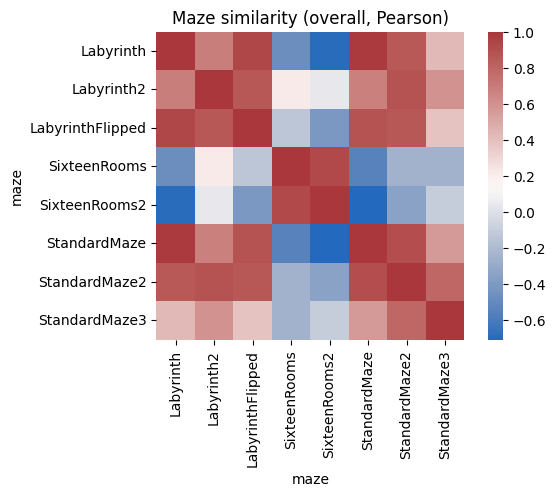

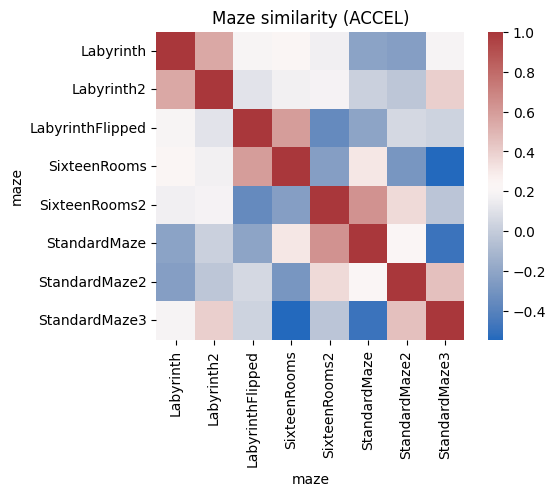

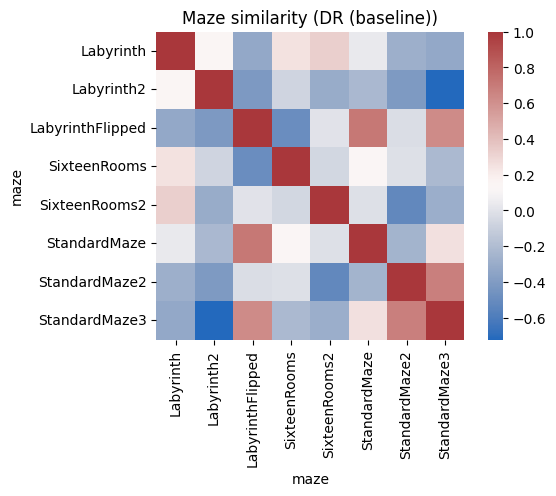

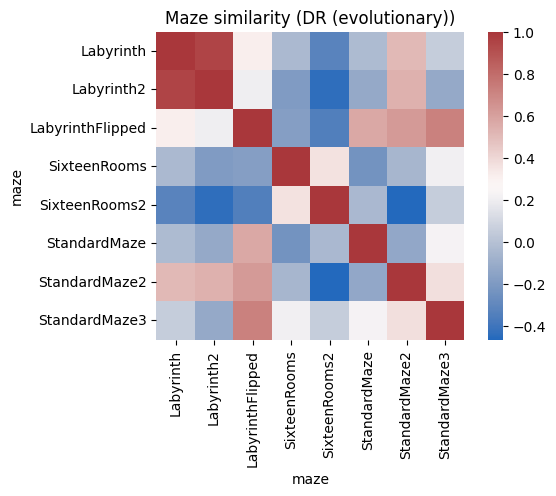

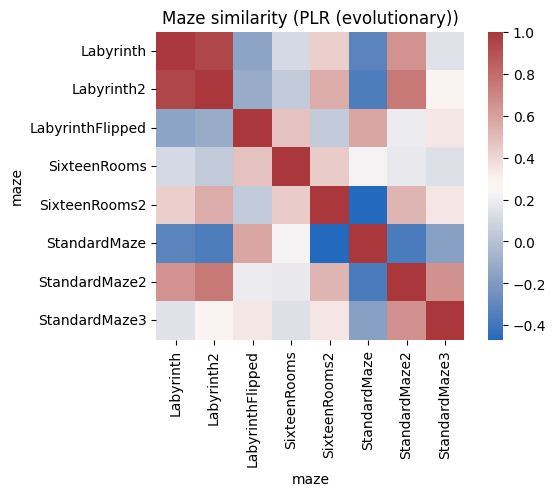

In [ ]:
from scripts.training_analyses import (
    compute_maze_similarity_overall, compute_maze_similarity_per_algorithm,
)
from scripts.training_plots import plot_similarity_heatmap

# Overall similarity among mazes (aggregating across algorithms)
maze_sim_overall = compute_maze_similarity_overall(df_perf, agg="mean", method="pearson")
plot_similarity_heatmap(maze_sim_overall, title="Maze similarity (overall, Pearson)", annotate=False)

# Similarity per algorithm (dict of DataFrames)
maze_sim_by_algo = compute_maze_similarity_per_algorithm(df_perf, method="pearson")

# Example: plot for each algorithm
for algo, mat in maze_sim_by_algo.items():
    plot_similarity_heatmap(mat, title=f"Maze similarity ({algo})", annotate=False)

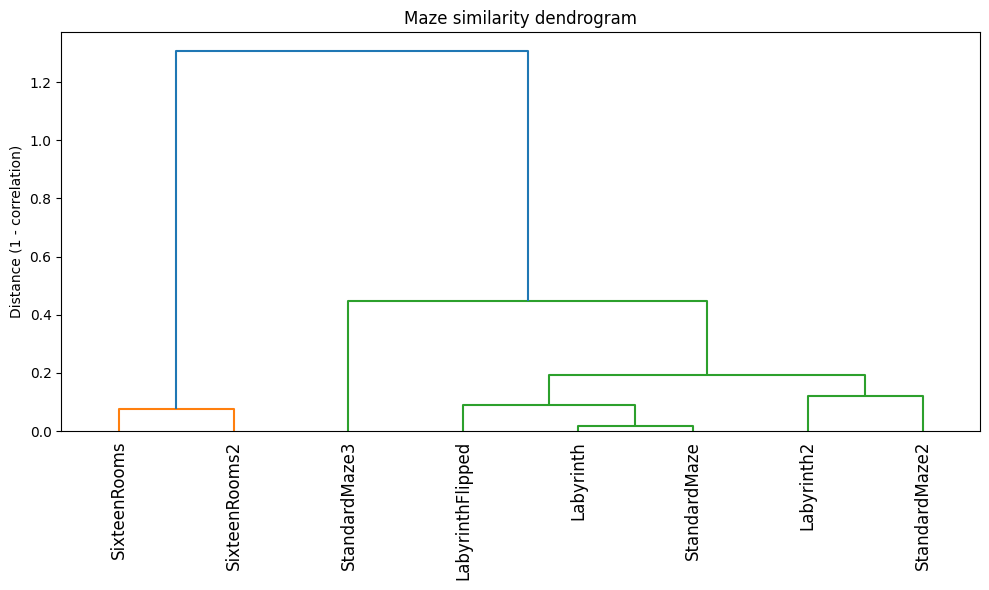

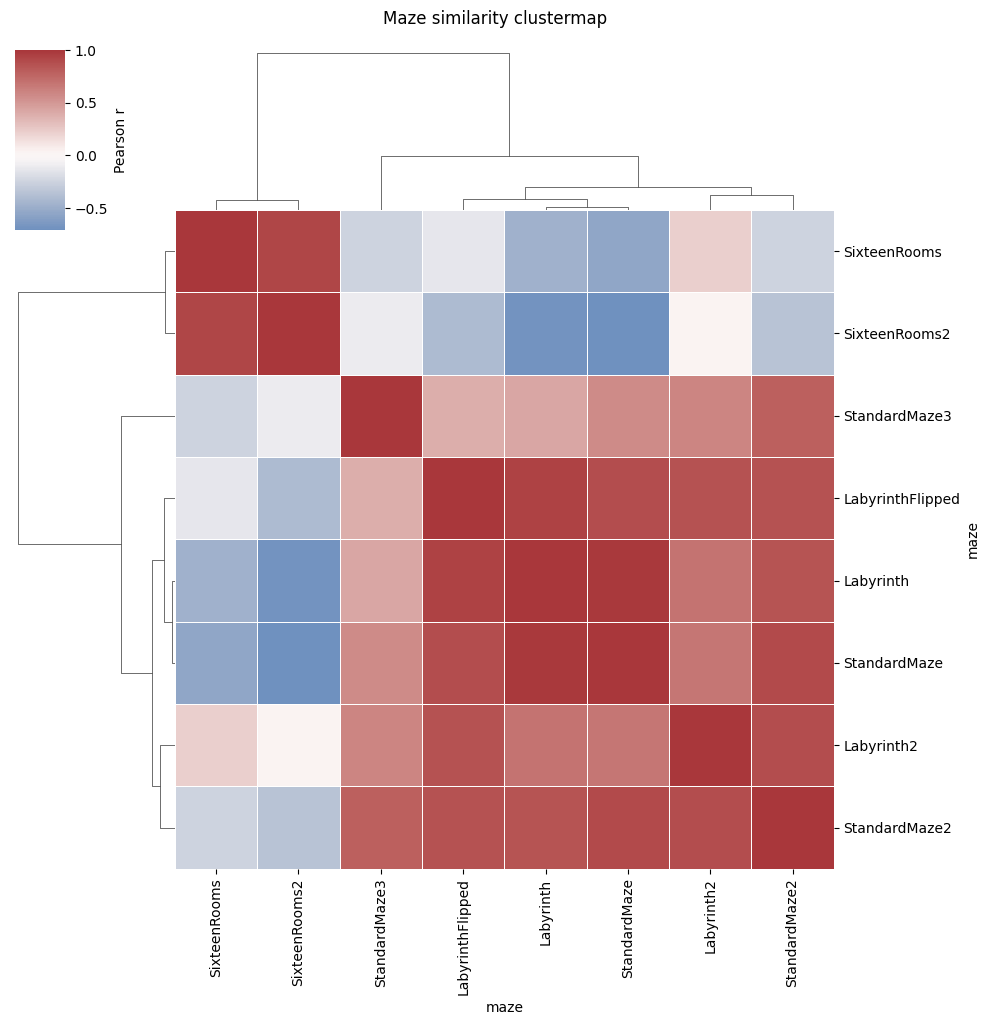

Labyrinth           2
Labyrinth2          2
LabyrinthFlipped    2
SixteenRooms        1
SixteenRooms2       1
StandardMaze        2
StandardMaze2       2
StandardMaze3       2
Name: cluster, dtype: int32

In [ ]:
from scripts.training_plots import plot_maze_similarity_clustering

# Cluster and plot maze similarity (dendrogram + clustermap)
result = plot_maze_similarity_clustering(
    df_perf,
    agg="mean",           # or "median"
    method="pearson",     # or "spearman", "cosine" (cosine works via compute_maze_similarity_overall)
    linkage_method="average",  # try "complete", "ward", etc.
    flat_threshold=0.6,   # distance threshold for optional flat clusters
    title_prefix="Maze similarity",
)

# Optional: view assigned cluster per maze
result.get("cluster_assignments")

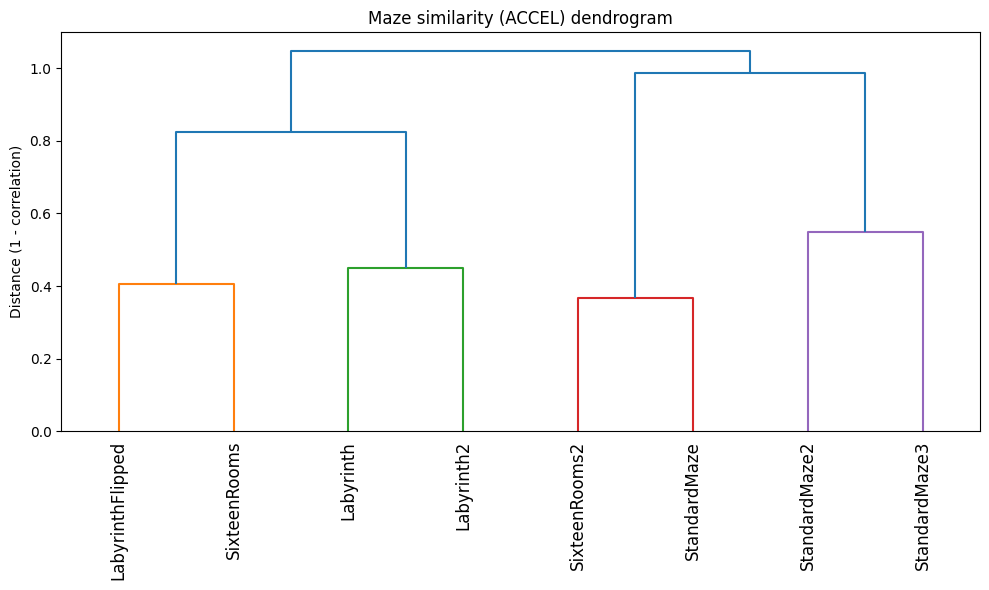

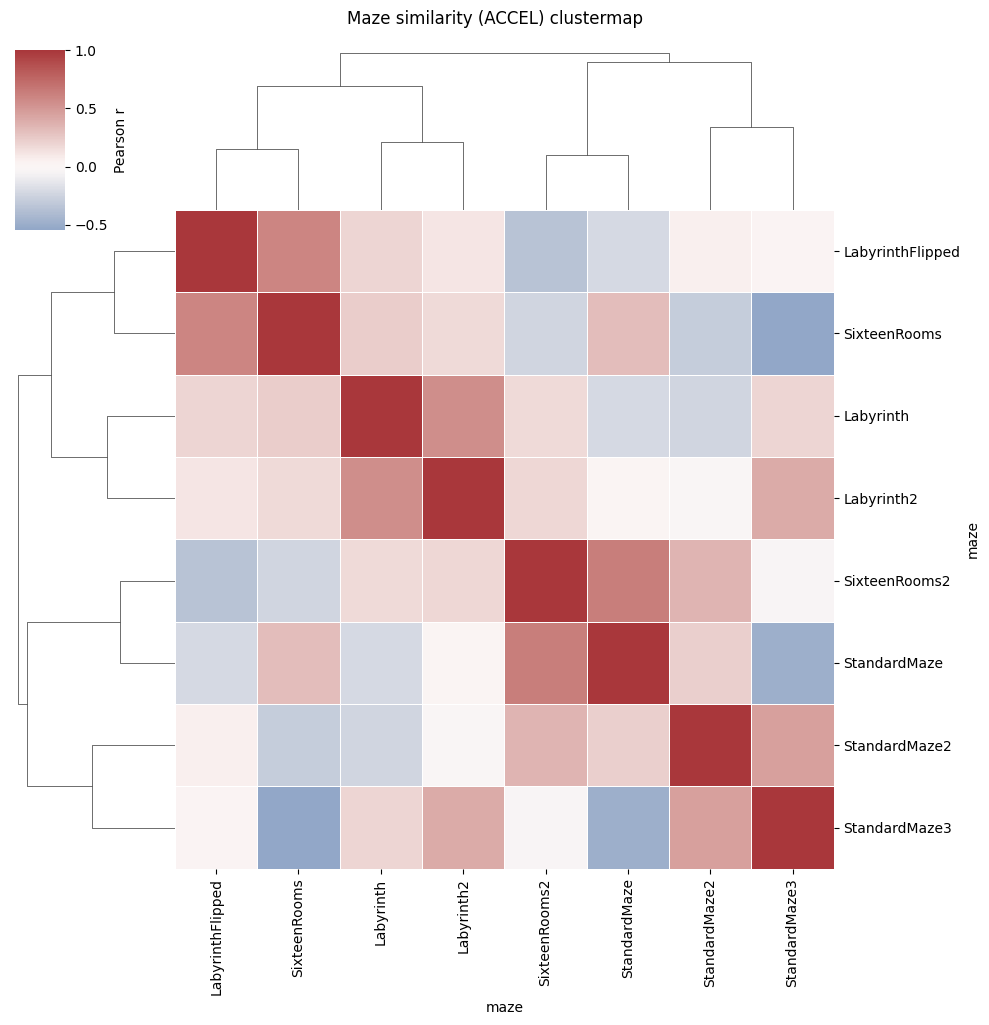

Labyrinth           2
Labyrinth2          2
LabyrinthFlipped    1
SixteenRooms        1
SixteenRooms2       3
StandardMaze        3
StandardMaze2       4
StandardMaze3       4
Name: cluster, dtype: int32

In [ ]:
from scripts.training_plots import plot_maze_similarity_clustering_for_algorithm

# ACCEL-only maze similarity clustering (dendrogram + clustermap)
accel_result = plot_maze_similarity_clustering_for_algorithm(
    df_perf,
    algorithm="ACCEL",
    method="pearson",       # or "spearman"
    linkage_method="average",  # try "complete", "ward"
    flat_threshold=0.6,     # adjust to change number of flat clusters
    title_prefix="Maze similarity (ACCEL)",
)

# Optional: inspect cluster labels for ACCEL
accel_result.get("cluster_assignments")

<Axes: title={'center': 'Per-maze per-algorithm (normalized)'}, xlabel='maze', ylabel='solve rate'>

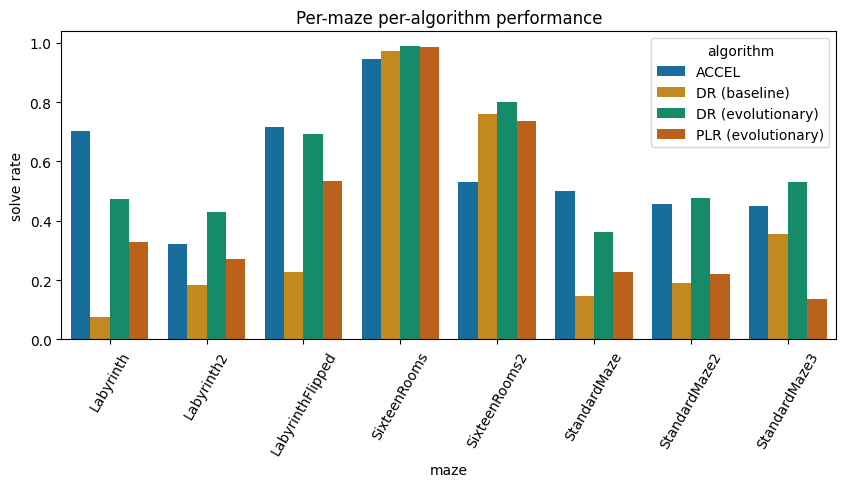

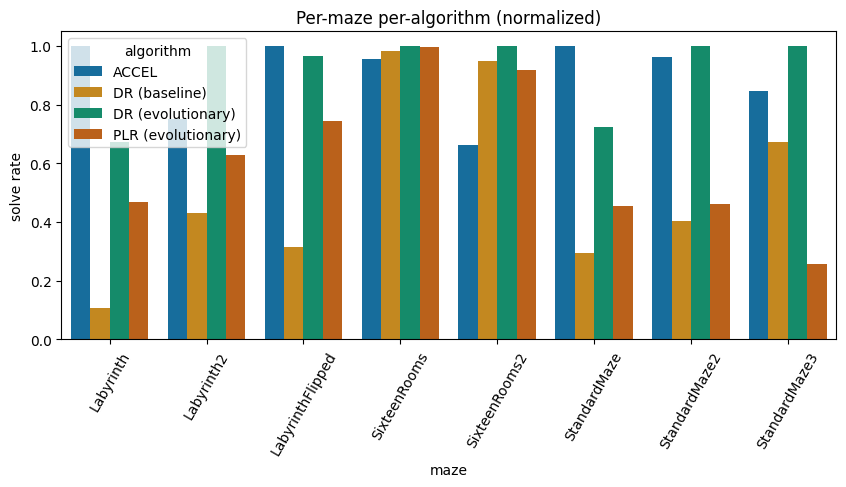

In [ ]:
from scripts.training_analyses import compute_winners_by_maze, plot_maze_algorithm_bars

# Aggregate and pivot to [maze x algorithm]
winners, values = compute_winners_by_maze(df_perf, agg="mean")

# Grouped bars: each maze on x-axis, bars per algorithm
plot_maze_algorithm_bars(values, title="Per-maze per-algorithm performance", normalize=False, y_label="solve rate")

# Optionally, normalized within each maze to [0,1] for comparability
plot_maze_algorithm_bars(values, title="Per-maze per-algorithm (normalized)", normalize=True, y_label="solve rate")

array([[<Axes: title={'center': 'ACCEL'}, ylabel='solve rate'>,
        <Axes: title={'center': 'DR (baseline)'}, ylabel='solve rate'>],
       [<Axes: title={'center': 'DR (evolutionary)'}, ylabel='solve rate'>,
        <Axes: title={'center': 'PLR (evolutionary)'}, ylabel='solve rate'>]],
      dtype=object)

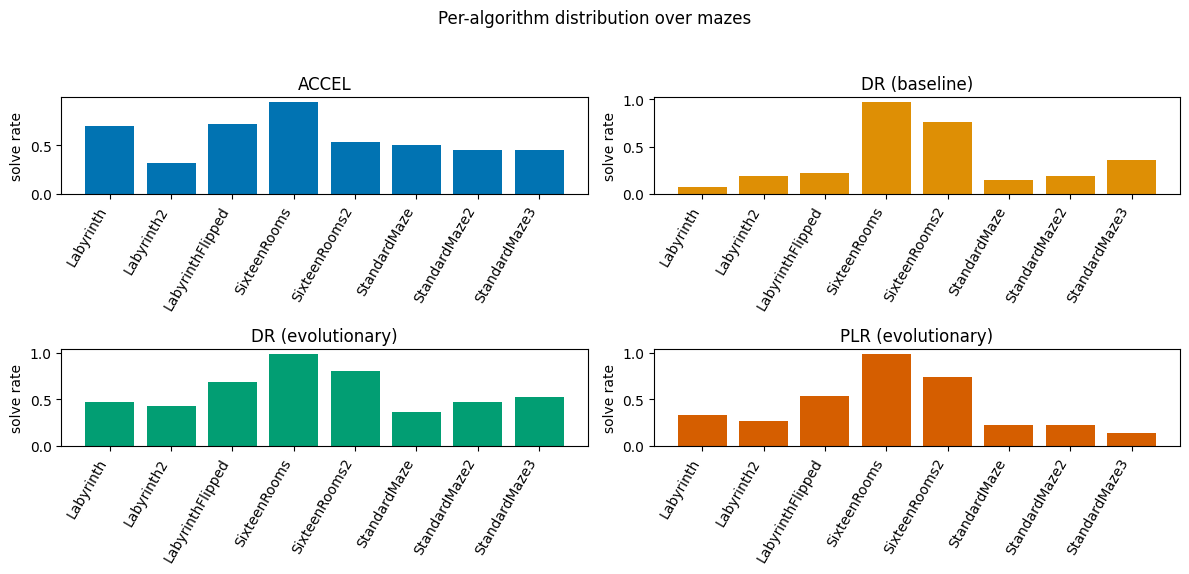

In [ ]:
from scripts.training_plots import plot_algorithm_facets_over_mazes

# One subplot per algorithm; bars over mazes
plot_algorithm_facets_over_mazes(
    values,
    title="Per-algorithm distribution over mazes",
    normalize=False,  # set True to scale each maze to [0,1]
    ncols=2,
    y_label="solve rate",
    y_lim_01=True,
)

array([[<Axes: title={'center': 'ACCEL'}, ylabel='solve rate'>,
        <Axes: title={'center': 'DR (baseline)'}, ylabel='solve rate'>],
       [<Axes: title={'center': 'DR (evolutionary)'}, ylabel='solve rate'>,
        <Axes: title={'center': 'PLR (evolutionary)'}, ylabel='solve rate'>]],
      dtype=object)

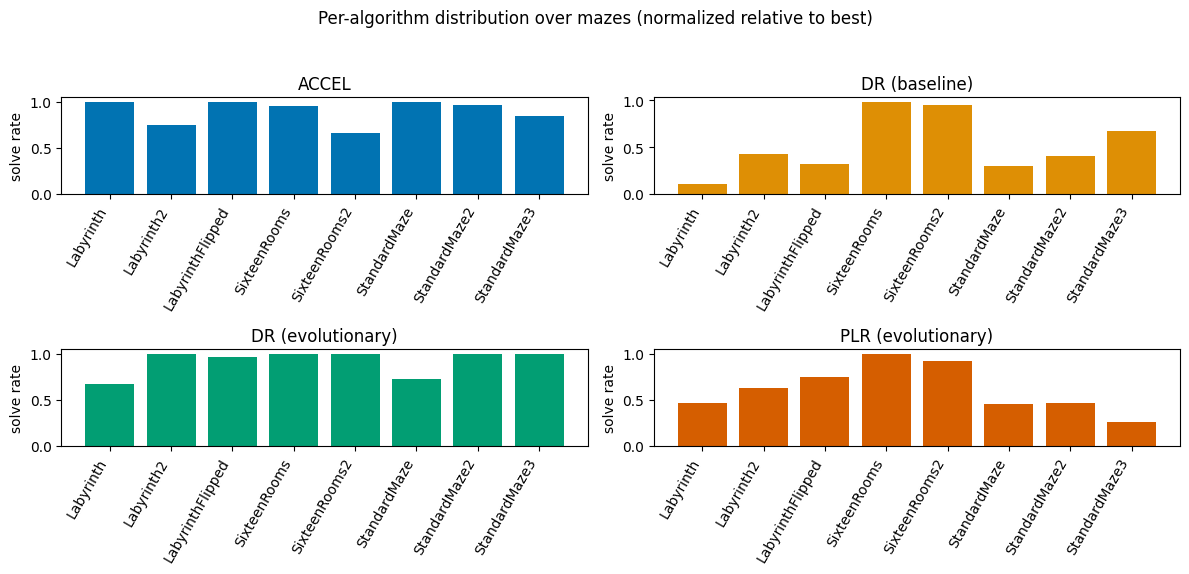

In [ ]:
from scripts.training_plots import plot_algorithm_facets_over_mazes

# Same plot as before, but values normalized within each maze to [0, 1]
plot_algorithm_facets_over_mazes(
    values,
    title="Per-algorithm distribution over mazes (normalized relative to best)",
    normalize=True,
    ncols=2,
    y_label="solve rate",
    y_lim_01=True,
)

<Axes: title={'center': 'Algorithm similarity (Pearson)'}, xlabel='group', ylabel='group'>

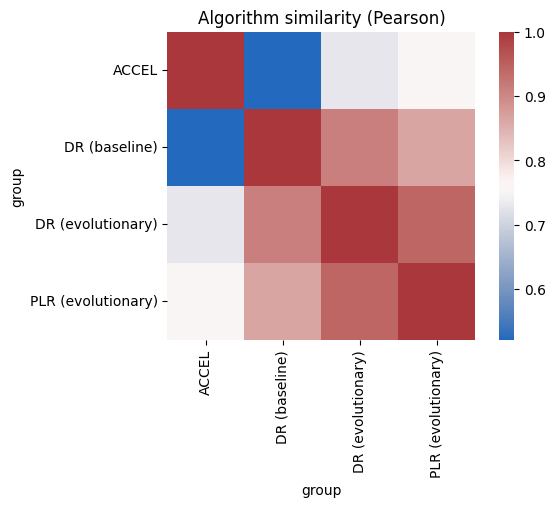

In [ ]:
from scripts.training_plots import compute_algorithm_similarity, plot_similarity_heatmap

# Rank-based similarity between algorithms across mazes
algo_sim_rank = compute_algorithm_similarity(df_perf, agg="mean", method="pearson")
plot_similarity_heatmap(algo_sim_rank, title="Algorithm similarity (Pearson)", annotate=False)